# EDA
In this notebook, I'll take a look at the data and create basic visualizations.

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import pickle

In [31]:
with open('PKL/timeseries_queens_p.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [32]:
df.head(2)

,11375,11377,11355,11385,11373,11372,11101,11368,11354,11374,...,11411,11426,11428,11693,11004,11416,11436,11366,11363,11430
10/2003,0.006411,0.000258,0.006179,0.014454,0.009119,0.010880,-0.005191,0.007736,0.002224,0.014723,...,0.009728,0.008042,0.005779,-0.002823,0.007665,0.006849,0.009621,0.008860,-0.010106,0.007301
11/2003,0.009131,0.000237,0.005411,0.010600,0.007955,0.009376,-0.007290,0.010456,0.003193,0.011095,...,0.008055,0.006078,0.006113,0.003619,0.006517,0.005124,0.002296,0.009759,-0.002934,0.005545


## Train/Test Split
I'll create a train only dataset to look at.

In [33]:
trdf = df.iloc[:int(len(df)*.8)]

In [98]:
trdf.index = pd.to_datetime(trdf.index)

## Average Values of Homes
Let's see what's the average values of homes in Queens in general.

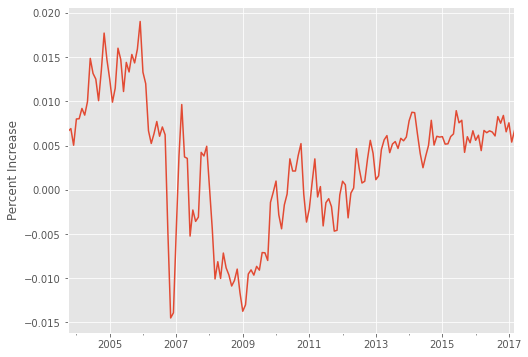

In [99]:
mean = np.mean(trdf, axis = 1)
ax = mean.plot(figsize = (8, 6))
plt.ylabel('Percent Increase')
plt.show()

We can see that the price increase dropped around the 2007 recession and unstable for a few years, then the price increase start to climb up. Recently the increase rate might have been start to stabilize. 

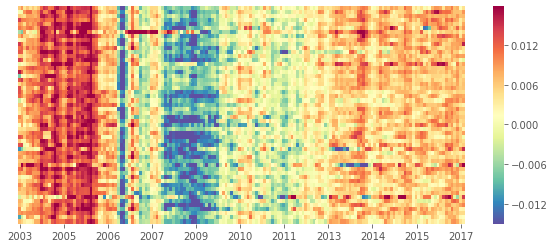

In [101]:
tmp = trdf.copy()
tmp.index = tmp.index.strftime('%Y')

fig = plt.figure(figsize = (10, 4))
ax = sns.heatmap(tmp.T, robust = True, cmap = 'Spectral_r', 
           yticklabels = False, xticklabels = 16)

plt.show()

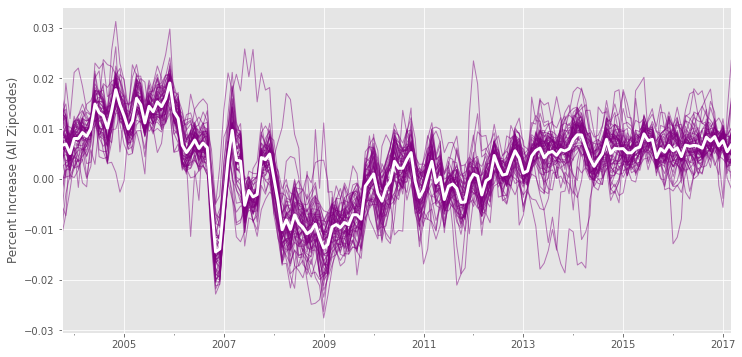

In [251]:
#other_zipcodes = list(trdf.columns.drop(select_zipcodes))
trdf.plot(figsize = (12, 6), lw = 1, color = 'purple', alpha = 0.5)
mean.plot(c = 'white', lw = 3)
plt.legend().set_visible(False)
plt.ylabel('Percent Increase (All Zipcodes)')
plt.show()


We can see that most neighborhoods in the queens tend to have pretty similar shift in percentage changes, but there are definitely handful of outliers (e.g. LIC) that went against the trend. Let's try to plot couple locations that's furthest away from the average line.

## Areas Against the Trend

In [102]:
# calculate absolute difference
diff_df = trdf.apply(lambda x: abs(x-mean))

In [244]:
# add up
diffs = np.sum(diff_df, axis = 0).sort_values(ascending = False)
select_zipcodes = list(diffs.index[0:5])
print(f'top 5 zipcodes with odd trends: {select_zipcodes}')


top 5 zipcodes with odd trends: [11101, 11693, 11692, 11694, 11103]


Mapping the odd locations

In [133]:
import folium
import json
from urllib.request import urlopen

In [164]:
diffdf = pd.DataFrame(diffs, columns = ['diff'])
diffdf = diffdf.reset_index()
diffdf = diffdf.rename(columns = {'index': 'zip'})
diffdf['zip'] = diffdf['zip'].astype('str')

Loading GeoJSON

In [178]:
geourl = 'https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ny_new_york_zip_codes_geo.min.json'
with urlopen(geourl) as url:
    geodata = json.load(url)

In [204]:
geo_feats = []
for i in range(len(geodata['features'])):
    if geodata['features'][i]['properties']['ZCTA5CE10']  in diffdf['zip'].values:
        geo_feats.append(geodata['features'][i])

In [215]:
geodata_sel = {}
geodata_sel['type'] = geodata['type']
geodata_sel['features'] = geo_feats

In [280]:
m = folium.Map(location=[40.73, -73.79])
folium.Choropleth(
    geo_data=geodata_sel,
    name='choropleth',
    data=diffdf,
    columns=['zip', 'diff'],
    key_on='properties.ZCTA5CE10',
    fill_color='BuPu',
    fill_opacity=0.9,
    line_weight=1,
    legend_name='Absolute Deviation from Average', 
).add_to(m)

folium.LayerControl().add_to(m)

m

It seems like the LIC and the Rockaway beach area tend to have different trend compared to overall average.

## Total Percent Increase
Now let's look at the total percent increase in all neighborhoods between 10/2003 to 03/2017

In [285]:
sumdf = pd.DataFrame(trdf.sum(), columns = ['sum'])
sumdf = sumdf.reset_index()
sumdf = sumdf.rename(columns = {'index': 'zip'})
sumdf['zip'] = sumdf['zip'].astype('str')

In [289]:
m = folium.Map(location=[40.73, -73.79])
folium.Choropleth(
    geo_data=geodata_sel,
    name='choropleth',
    data=sumdf,
    columns=['zip', 'sum'],
    key_on='properties.ZCTA5CE10',
    fill_color='BuPu',
    fill_opacity=0.9,
    line_weight=1,
    legend_name='Total Percent Increase', 
).add_to(m)

folium.LayerControl().add_to(m)

m

Overall areas closer to Manhattan did increased more total percent increase with a fewer exception (e.g. nearing airport)

## Median Increase
Now let's look at each neighborhood's median percent increase.

In [287]:
mediandf = pd.DataFrame(trdf.median(), columns = ['median'])
mediandf = mediandf.reset_index()
mediandf = mediandf.rename(columns = {'index': 'zip'})
mediandf['zip'] = mediandf['zip'].astype('str')

In [290]:
m = folium.Map(location=[40.73, -73.79])
folium.Choropleth(
    geo_data=geodata_sel,
    name='choropleth',
    data=mediandf,
    columns=['zip', 'median'],
    key_on='properties.ZCTA5CE10',
    fill_color='BuPu',
    fill_opacity=0.9,
    line_weight=1,
    legend_name='Median Percent Increase', 
).add_to(m)

folium.LayerControl().add_to(m)

m

Generally all neighborhoods had an upward trend at all time.